<a href="https://colab.research.google.com/github/S-Ngigi/ML/blob/master/TrafficSign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensor Play

Experimenting with the tensor flow gpu environment.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [2]:
"""
Bench-marking CPU vs GPU
"""

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100,100,100,3))
    net_cpu =  tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print(f'GPU speedup over CPU: {int(cpu_time/gpu_time)}x')

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.967622761999962
GPU (s):
0.09901644899997564
GPU speedup over CPU: 29x


PyTorch Tensor

Numpy based operations are not optimized to utilize GPUs to accelerate its numerical computations. 

For mordern deep neural networks GPUs often provides speed ups of 50x or greater so unfortunately numpy isn't enough for modern deep learning. 

PyTorch introduces the **Tensor** concept that is conceptuallyl identical to an n-dimensional numpy array but can utilize GPUs to accelerate their numeric computations.

Lets explore them

In [0]:
import torch, numpy
import matplotlib.pyplot as plt

In [0]:
# The defaul tensor type in PyTorch is a float tensor - torch.FloatTensor
x = torch.ones(3,2)
y = torch.zeros(3,2)
print(x)
print(y)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])


In [0]:
# To increase reproducibility, we oftern set the random seed to specific value first
torch.manual_seed(2)
x=torch.rand(3, 2)
print(x)
x=torch.randn(3, 3) # for a tensor with normally distributed random values
print(x)

tensor([[0.6147, 0.3810],
        [0.6371, 0.4745],
        [0.7136, 0.6190]])
tensor([[-2.1409, -0.5534, -0.5000],
        [-0.0815, -0.1633,  1.5277],
        [-0.4023,  0.0972, -0.5682]])


In [3]:
# Getting the data onto Colab
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [4]:
# 
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


An alternative approach to loading the data. Here we use the kaggle api to load data directly into colab

In [5]:
# Colab library to upload files to notebook
from google.colab import files

# Installing Kaggle Library
!pip install -q kaggle

     |████████████████████████████████| 122kB 18.4MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [6]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [10]:
!cd ~ && mkdir .kaggle/

mkdir: cannot create directory ‘.kaggle/’: File exists


In [13]:

!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [12]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 601M/612M [00:10<00:00, 55.7MB/s]
100% 612M/612M [00:10<00:00, 62.5MB/s]


In [14]:
# Checking the contents of the current directory. Note the german traffic zip
!ls .

german-traffic-signs  gtsrb-german-traffic-sign.zip  sample_data


In [0]:
# Importing Libraries
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [0]:
# For reproducability
np.random.seed(0)

We create the function below to help load the images from their pickle format

In [33]:
# Defining a function to load the pictures based on specific dataset & features
def pickle_dataLoader(data_set, columns):
  # Opening the folder
  with open(f'german-traffic-signs/{data_set}', 'rb') as data:
    # Loading the data
    imgs = pickle.load(data)
  # returning a tuple of the images and the col_needed.
  return tuple(map(lambda x: imgs[x], columns))

# Defining our columns
data_cols = ['features', 'labels']

# Loading our data
X_train, Y_train = pickle_dataLoader('train.p', data_cols)
X_val, Y_val = pickle_dataLoader('valid.p', data_cols)
X_test, Y_test = pickle_dataLoader('test.p', data_cols)


# Checking the shape
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


In [34]:
# Getting the signnames
data = pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


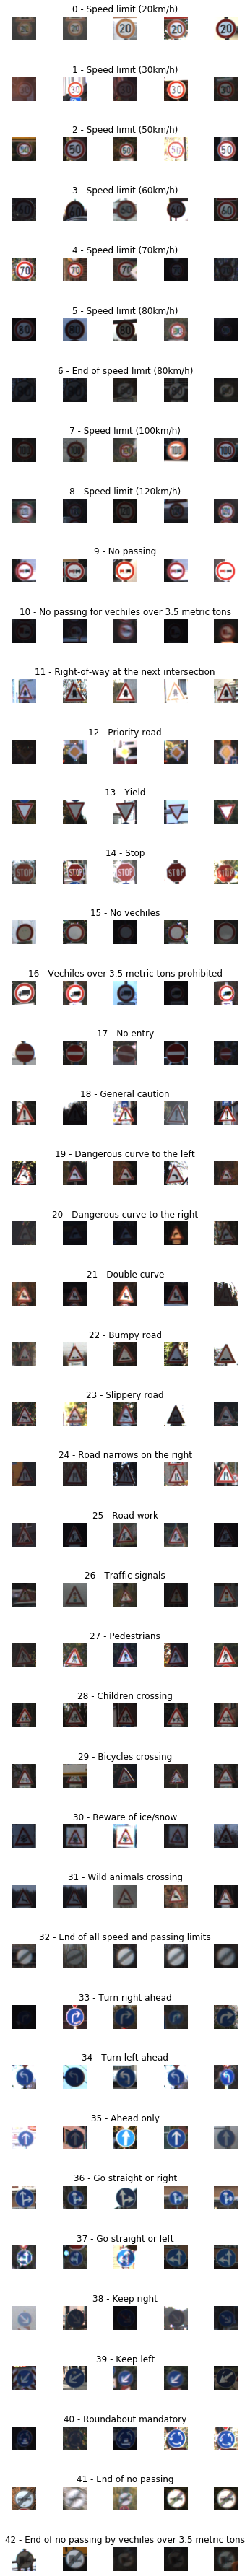

In [35]:
num_of_samples = []
# How many cols we would like per class
cols = 5
# Total number of classes
num_classes = data.shape[0] # 43 classes for this classification

# Initializing the plot
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

# Outer loop for the number of columns we desire
for i in range(cols):
  # Returns the index in data and its row values
  for j, row in data.iterrows():
    """
      Because X_train and Y_train are ordered in the same way, the code below 
      makes sure that images belonging to the same category/class are displayed together.

      This is only limited by the number of colums we would like to display for 
      each category/class
    """
    x_selected = X_train[Y_train==j]
    # Choose randomly the images that will be used in the sample
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :],
                     cmap=plt.get_cmap('gray'))
    # Something about the axis
    axs[j][i].axis("off")
    if i == 2:
      # Setting the title for the second image. This helps us align the title in
      # the middle
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      # Here we are appending only the se
      num_of_samples.append(len(x_selected))

In [0]:
x_train[y_train == 0].shape

(180, 32, 32, 3)

In [26]:
Y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [37]:
len(num_of_samples)

43

In [38]:
num_of_samples

[180,
 1980,
 2010,
 1260,
 1770,
 1650,
 360,
 1290,
 1260,
 1320,
 1800,
 1170,
 1890,
 1920,
 690,
 540,
 360,
 990,
 1080,
 180,
 300,
 270,
 330,
 450,
 240,
 1350,
 540,
 210,
 480,
 240,
 390,
 690,
 210,
 599,
 360,
 1080,
 330,
 180,
 1860,
 270,
 300,
 210,
 210]

Alternatively trying to do the same when we start with the actual images instead of binary representations

In [0]:
import os
import zipfile as zp

gts_zip = zp.ZipFile('gtsrb-german-traffic-sign.zip', 'r')
gts_dirs = list(set([os.path.dirname(x) for x in gts_zip.namelist()]))
topDirs = [os.path.split(x)[0] for x in gts_dirs]

In [42]:
set(topDirs)

{'', 'Train', 'train'}

In [0]:
gts_dirs = list(set([x for x in gts_zip.namelist() if x.endswith(".csv")]))


In [47]:
gts_dirs

['Test.csv',
 'test/GT-final_test.csv',
 'Train.csv',
 'Test/GT-final_test.csv',
 'Meta.csv']

In [0]:
train_csv = pd.read_csv(gts_zip.open('Train.csv'))
test_csv = pd.read_csv(gts_zip.open('Test.csv'))
# testGT_csv = pd.read_csv(gts_zip.open('/test/GT-final_test.csv'),header=None, delim_whitespace=True)
# TestGT_csv = pd.read_csv(gts_zip.open('Test/GT-final_test.csv'), delimiter=',')
meta_csv = pd.read_csv(gts_zip.open('Meta.csv'))

In [74]:
print(train_csv.shape)
train_csv.head()

(39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [75]:
print(test_csv.shape)
test_csv.head()

(12630, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [76]:
print(meta_csv.shape)
meta_csv.head()

(43, 5)


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


### Image processing using PIL

In [0]:
from PIL import Image
from io import StringIO
from io import BytesIO

In [0]:
def img_to_ndarray(img_path, height, width, ncategories):

  imgs = []
  labels = []
  
  for cat in range(ncategories):

    

In [80]:
gts_img_path = list(set([x for x in gts_zip.namelist() if x.endswith(".png") and 'Train' in x]))
len(gts_img_path)

39209

We may need to sort the gts_img_path by **Train/num/pic_id.**

In [81]:
gts_img_path[0]

'Train/7/00007_00027_00011.png'

In [91]:
img_zip = gts_zip.read(gts_img_path[0])
img_enc = BytesIO(img_zip)
img = Image.open(img_enc)
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x33 at 0x7F48B061EE10>


In [0]:
img.show()

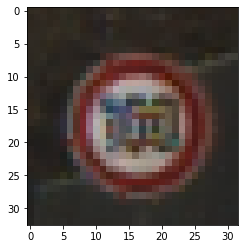

In [94]:
import matplotlib.image as mpimg

img = mpimg.imread(gts_zip.open(gts_img_path[0]))
# print(img)
imgplot = plt.imshow(img)